In [1]:
import numpy as np
import pandas as pd
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

In [2]:
def rename_triad_entity(st):
    s = st.split('.')
    rdexp = '_'.join(s[1].split('_')[:2])
    return '.'.join([s[0],rdexp, s[3]])

real = pd.read_csv("real_data.tsv", sep='\t', header=None).rename(columns={0:"fname", 1:"triad_count"}).iloc[:-1, :]
real["fname"] = real["fname"].apply(lambda x: x.split('/')[-1])
real["fname"] = real["fname"].apply(lambda x: rename_triad_entity(x))
real

,fname,triad_count
0,CBP.redc_K562.fRIP,523
1,CBX3.redc_K562.fRIP,881
2,CHD1.redc_K562.fRIP,11252
3,CHD4.redc_K562.fRIP,3153
4,CHD7.redc_K562.fRIP,881
...,...,...
57,WDR5.radiclNPM_mESC.fRIP,498
58,WDR5.redc_K562.fRIP,10677
59,YBX3.redc_K562.eCLIP,40
60,ZC3H11A.redc_K562.eCLIP,719


In [3]:
sim = pd.read_table("simres_cnts.tsv", index_col=0)
sim

,itr,Prot,triad_count
0,0,KHSRP.redc_K562.eCLIP,121
1,0,RBFOX2.redc_K562.eCLIP,1711
2,0,CHD7.redc_K562.fRIP,68
3,0,HDAC1.redc_K562.fRIP,796
4,0,FUS.redc_K562.eCLIP,63
...,...,...,...
588995,9999,PTBP1.redc_K562.eCLIP,393
588996,9999,SRSF9.redc_K562.eCLIP,1
588997,9999,ZC3H11A.redc_K562.eCLIP,90
588998,9999,SRSF7.redc_K562.eCLIP,15


In [4]:
cnts = (pd.merge(sim, real, left_on="Prot", right_on="fname", suffixes=["_sim", "_real"])
        .iloc[:, [0,1,2,4]])
cnts["triad_count_real"] = np.log10(cnts.triad_count_real)
cnts["triad_count_sim"] = np.log10(cnts.triad_count_sim)

In [5]:
cnts[cnts.triad_count_real <= cnts.triad_count_sim].Prot.value_counts()

Prot
WDR5.grid_mESC.fRIP       9900
RBFOX2.redc_K562.eCLIP    4239
HNRNPL.redc_K562.eCLIP    1699
YBX3.redc_K562.eCLIP       854
KHSRP.redc_K562.eCLIP      360
SUZ12.redc_K562.fRIP       151
Name: count, dtype: int64

In [6]:
remodelling = ["CBP", "CBX3", "CHD1", "CHD4", "CHD7", "CTCF", "DNMT1", "EZH2", "HDAC1",
        "HLTF", "LSD1", "MORC2", "PCAF", "PHF8", "RBBP5", "SAFB", "SAFB2", "SUZ12", "WDR5"]
processing = ["FUS", "HNRNPC", "HNRNPH", "HNRNPK", "HNRNPL",
        "HNRNPUL1", "ILF3", "KHSRP", "LARP7", "NONO", "NUP98", "PTBP1", "RBFOX2", "RBM15",
        "RBM22", "SRSF1", "SRSF7", "SRSF9", "TARDBP", "U2AF1", "U2AF2", "ZC3H11A",]
transcription = ["CHD7", "EWSR1", "FUS", "GTF2F1", "HLTF",
        "HNRNPK", "HNRNPUL1", "LARP7", "PCBP1", "RBM15", "TAF15", "U2AF2", "YBX3", "ZC3H8",]

In [7]:
def get_cat(val):
    val = val.split('.')[0]
    if val in remodelling:
        return "remodelling"
    if val in processing:
        return "processing"
    if val in transcription:
        return "transcription regulation"

In [8]:
dt = {"remodelling": 'o', "processing": '*', "transcription regulation": "x"}
cnts["type"] = cnts.Prot.apply(lambda x: get_cat(x))
cnts["marker"] = cnts.type.apply(lambda x: dt[x])

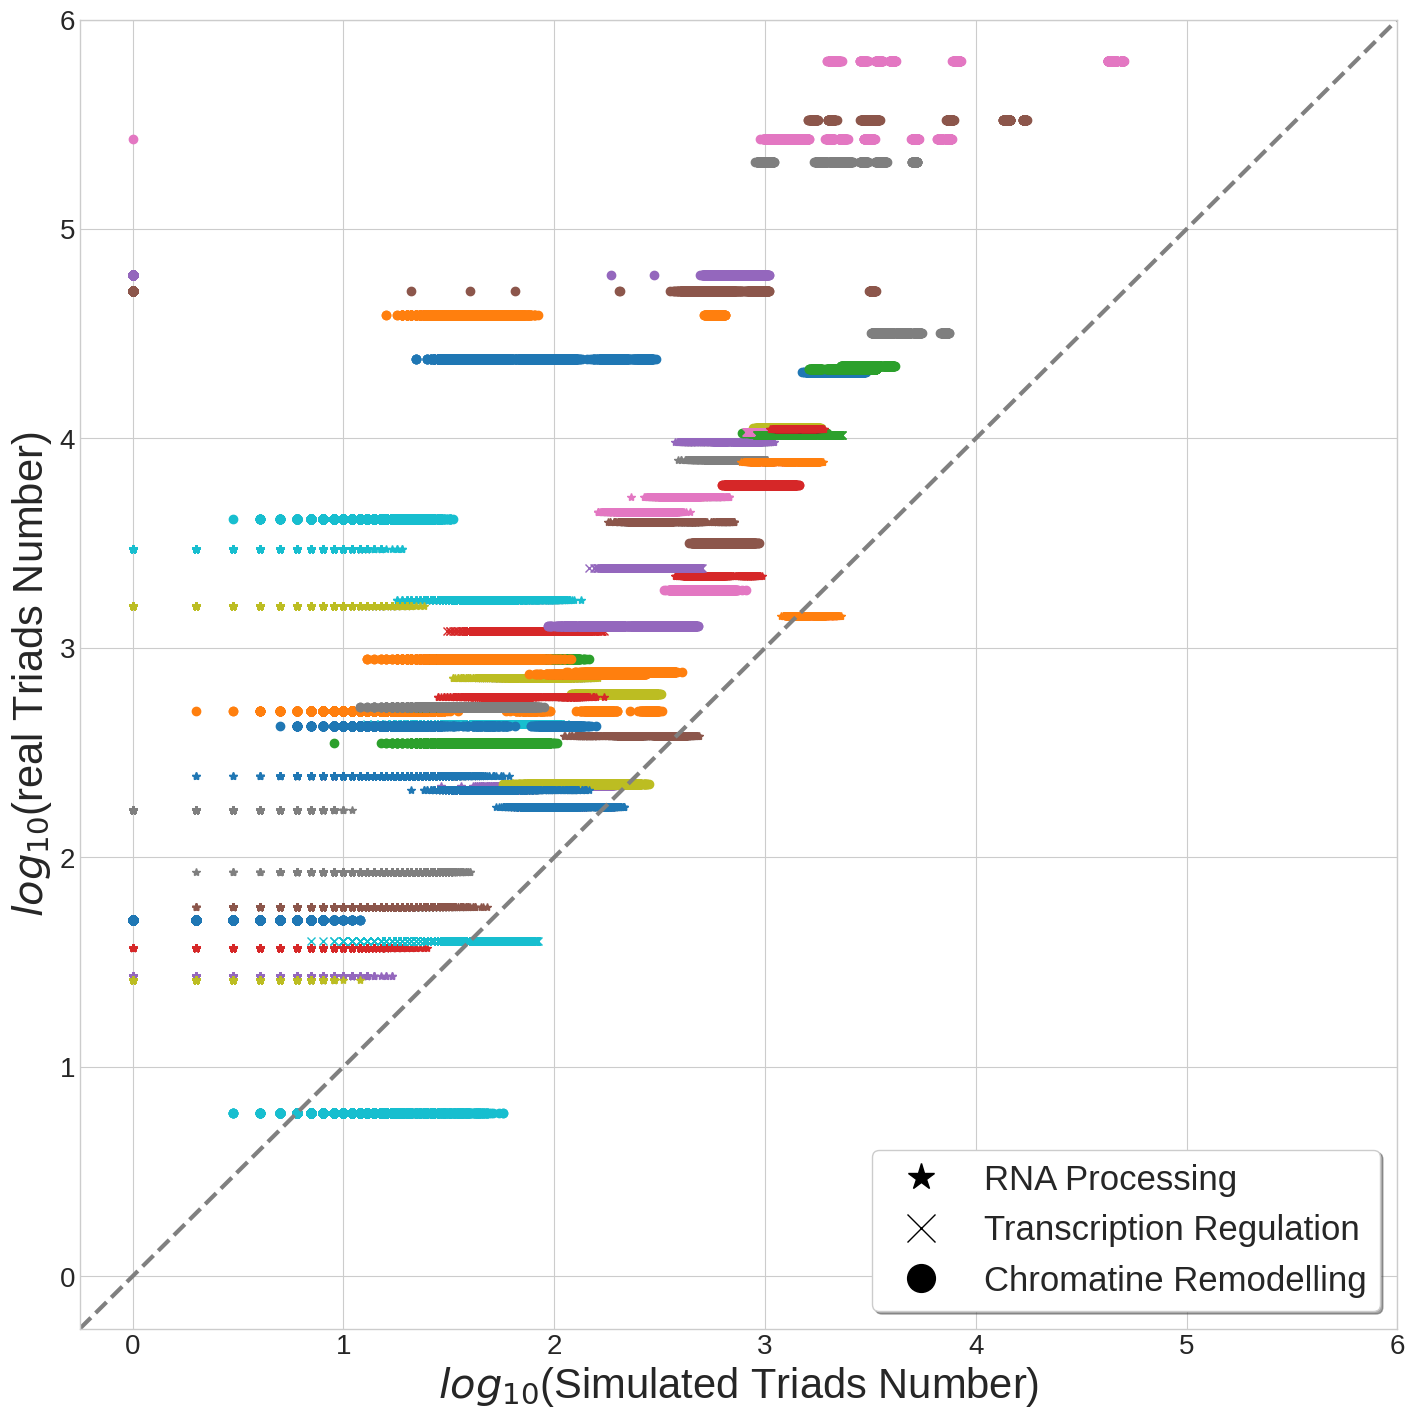

<Figure size 640x480 with 0 Axes>

In [10]:
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(17, 17))
for protein in cnts.Prot.unique():
    tmp_df = cnts.query(f"Prot == '{protein}'")
    plt.plot(tmp_df.triad_count_sim, tmp_df.triad_count_real, marker=tmp_df.marker.unique()[0],
            lw = 0, label=tmp_df.type.unique()[0])
    
plt.axline((0,0), slope=1, color='grey', lw=3, ls='--')
plt.xlim([-0.25, 6])
plt.ylim([-0.25, 6])
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("$log_{10}$(Simulated Triads Number)", fontsize=30)
plt.ylabel("$log_{10}$(real Triads Number)", fontsize=30)

proc_patch = mlines.Line2D([], [], color='black', marker='*', linestyle='None',
                          markersize=20, label='RNA Processing')
trans_patch = mlines.Line2D([], [], color='black', marker='x', linestyle='None',
                          markersize=20, label='Transcription Regulation')
remod_patch = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=20, label='Chromatine Remodelling')

plt.legend(handles=[proc_patch, trans_patch, remod_patch], 
           loc='lower right', fontsize=25, shadow=True, frameon=True)

plt.show()
plt.savefig("triad_numbers.svg", transparent=True)